<a href="https://colab.research.google.com/github/koeyhnim/banghak/blob/chap-4/my_notebook_chap4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
    import torch

x = torch.ones(2, 3, requires_grad=True)
print(x)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)


In [19]:
y = x + 2
print(y)
print(y.grad_fn)

tensor([[3., 3., 3.],
        [3., 3., 3.]], grad_fn=<AddBackward0>)


In [20]:
z = y * 3
print(z)

out = z.mean()
print(out)

tensor([[9., 9., 9.],
        [9., 9., 9.]], grad_fn=<MulBackward0>)
tensor(9., grad_fn=<MeanBackward0>)


In [22]:
a = torch.tensor([1.0], requires_grad=True)
b = a * 2  # b의 변화량은 a의 2배
b.backward()  # 역전파
print(a.grad)  # a의 경사(a의 변화에 대한 b의 변화 비율)

tensor([2.])


In [23]:
def calc(a):
    b = a*2 + 1
    c = b*b
    d = c/(c + 2)
    e = d.mean()
    return e

x = [1.0, 2.0, 3.0]
x = torch.tensor(x, requires_grad=True)
y = calc(x)
y.backward()
print(x.grad)  # x의 경사(x의 각 값의 변화에 대한 y의 변화 비율)

tensor([0.0661, 0.0183, 0.0072])


In [24]:
delta = 0.001  #x의 미소 변화

x = [1.0, 2.0, 3.0]
x = torch.tensor(x)
y = calc(x)

x_1 = [1.0+delta, 2.0, 3.0]
x_1 = torch.tensor(x_1)
y_1 = calc(x_1)

x_2 = [1.0, 2.0+delta, 3.0]
x_2 = torch.tensor(x_2)
y_2 = calc(x_2)

x_3 = [1.0, 2.0, 3.0+delta]
x_3 = torch.tensor(x_3)
y_3 = calc(x_3)

# 경사 계산(y의 미소 변화)/(x의 미소 변화)
grad_1 = (y_1 - y) / delta
grad_2 = (y_2 - y) / delta
grad_3 = (y_3 - y) / delta

grads = torch.stack((grad_1, grad_2, grad_3))  # Tensor를 결합
print(grads)

tensor([0.0660, 0.0183, 0.0072])


In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms

img_size = 28  # 이미지의 높이와 폭

# 훈련 데이터를 취득
mnist_train = MNIST("./data",
                    train=True, download=True,
                    transform=transforms.ToTensor())  # Tensor로 변환
# 테스트 데이터의 취득
mnist_test = MNIST("./data",
                   train=False, download=True,
                   transform=transforms.ToTensor())  # Tensor로 변환

print("훈련 데이터의 수:", len(mnist_train), "테스트 데이터의 수:", len(mnist_test))

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.1MB/s]

훈련 데이터의 수: 60000 테스트 데이터의 수: 10000


In [2]:
from torch.utils.data import DataLoader

# DataLoader의 설정
batch_size = 256  # 배치 크기
train_loader = DataLoader(mnist_train,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(mnist_test,
                         batch_size=batch_size,
                         shuffle=False)

In [3]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(img_size*img_size, 1024)  # 전결합층
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()  # ReLU 학습하는 파라미터가 없으므로 다시 사용할 수 있다

    def forward(self, x):
        x = x.view(-1, img_size*img_size) # (배치 크기, 입력의 수): 이미지를 1차원으로 변환
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.cuda()  # GPU 대응
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)


In [4]:
from torch import optim

# 교차 엔트로피 오차 함수
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 손실 로그
record_loss_train = []
record_loss_test = []

# 학습
for i in range(10):  # 10 에포크 학습
    net.train()  # 훈련 모드
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # 미니배치 (x, t)를 꺼낸다
        x, t = x.cuda(), t.cuda()  # GPU 대응
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 평가 모드
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):  # 미니 배치 (x, t)를 꺼낸다
        x, t = x.cuda(), t.cuda()  # GPU 대응
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 2.2241463295956874 Loss_Test: 2.104907613992691
Epoch: 1 Loss_Train: 1.8480157121698908 Loss_Test: 1.4735356986522674
Epoch: 2 Loss_Train: 1.1408740510331823 Loss_Test: 0.8499669834971428
Epoch: 3 Loss_Train: 0.7357665904024814 Loss_Test: 0.6120052590966225
Epoch: 4 Loss_Train: 0.5732959167754397 Loss_Test: 0.5024879381060601
Epoch: 5 Loss_Train: 0.4919088395352059 Loss_Test: 0.4422836281359196
Epoch: 6 Loss_Train: 0.4423240652743806 Loss_Test: 0.40488915555179117
Epoch: 7 Loss_Train: 0.40968721306070366 Loss_Test: 0.37784047350287436
Epoch: 8 Loss_Train: 0.38638960351335244 Loss_Test: 0.3579764772206545
Epoch: 9 Loss_Train: 0.36808814653690825 Loss_Test: 0.3438104228116572


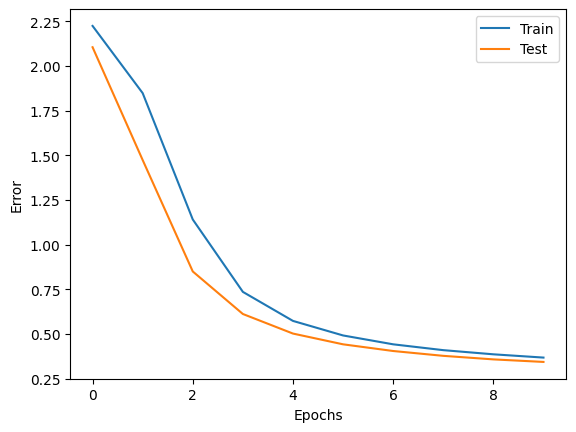

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [7]:
correct = 0
total = 0
net.eval()  # 평가 모드
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU 대응
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("정답률:", str(correct/total*100) + "%")

정답률: 90.32%


In [8]:
from torchvision.datasets import MNIST
from torchvision import transforms

img_size = 28  # 이미지의 높이와 폭

# 훈련 데이터를 취득
mnist_train = MNIST("./data",
                    train=True, download=True,
                    transform=transforms.ToTensor())  # 텐서로 변환
# 테스트 데이터의 취득
mnist_test = MNIST("./data",
                   train=False, download=True,
                   transform=transforms.ToTensor())  # 텐서로 변환

print("훈련 데이터의 수:", len(mnist_train), "테스트 데이터의 수:", len(mnist_test))

훈련 데이터의 수: 60000 테스트 데이터의 수: 10000


In [19]:
from torch.utils.data import DataLoader

batch_size = 256
train_loader = DataLoader(mnist_train,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(mnist_test,
                         batch_size=batch_size,
                         shuffle=False)


In [20]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(img_size*img_size, 1024)  # 전결합층
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()  # ReLU 학습하는 파라미터가 없으므로 다시 사용할 수 있다

    def forward(self, x):
        x = x.view(-1, img_size*img_size)  # (배치 크기, 입력의 수): 이미지를 1차원으로 변환
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.cuda()  # GPU 대응
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
)


In [23]:
from torch import optim

# 교차 엔트로피 오차 함수
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 손실의 로그
record_loss_train = []
record_loss_test = []

# 학습
for i in range(5):  # 5 에포크 학습
    net.train()  # 훈련 모드
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # 미니배치 (x, t)를 꺼낸다
        x, t = x.cuda(), t.cuda()  # GPU 대응
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 평가 모드
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):  # 미니배치 (x, t)를 꺼낸다
        x, t = x.cuda(), t.cuda()  # GPU 대응
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 0.46124754294436027 Loss_Test: 0.4181626051664352
Epoch: 1 Loss_Train: 0.42200614315398194 Loss_Test: 0.38582677245140073
Epoch: 2 Loss_Train: 0.39470391527135323 Loss_Test: 0.36404911763966086
Epoch: 3 Loss_Train: 0.3741325666295721 Loss_Test: 0.3468619169667363
Epoch: 4 Loss_Train: 0.35793057274311146 Loss_Test: 0.33302352521568535


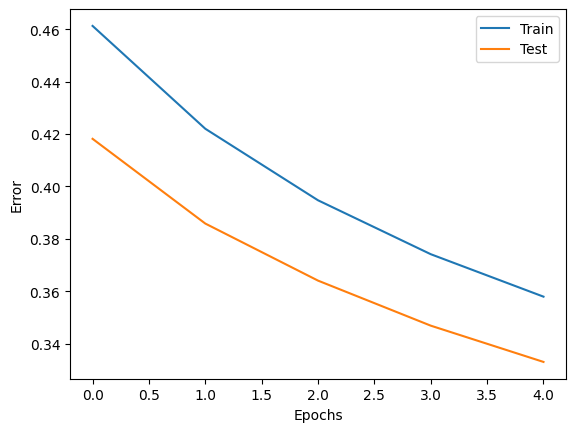

In [27]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [28]:
correct = 0
total = 0
net.eval()  # 평가 모드
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU 대응
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("정답률:", str(correct/total*100) + "%")

정답률: 90.49000000000001%
